# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [79]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import os

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score,accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
#from sklearn.externals.six import StringIO   CHECK THISSSSSSSSSSSSSSS!!!
from IPython.display import Image  
from sklearn.tree import export_graphviz
#from scipy.interpolate import spline         CHECK THISSSSSSSSSSSSSSS!!!

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [6]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = ((data['loan_status'] == 'Charged Off') | (data['loan_status'] == 'Default'))

In [7]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.add('cr_hist')

In [8]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice(np.array([True,False]),len(data),p = [0.7,0.3])

In [9]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [75]:
data['train'].sum()/data['train'].count()

0.6999858777791008

## Prepare functions to fit and evaluate models

In [11]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [12]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
        print(y_pred_probs)
        dump_to_output("pred probs",y_pred_probs)
        
    a = f1_score(y_test, y_pred, average='weighted')
        
    return out,a

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [76]:
continuous_features = list(continuous_features)

In [77]:
## define your set of features to use in different models
your_features = discrete_features + list(continuous_features) +['cr_hist','train']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Random Classifier

In [80]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(data_dict['X_train'], data_dict['y_train'])
y_pred = dummy_clf.predict(data_dict['X_test'])

print(classification_report(data_dict['y_test'], y_pred))

              precision    recall  f1-score   support

       False       0.79      0.50      0.61     15764
        True       0.21      0.50      0.30      4236

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.46     20000
weighted avg       0.67      0.50      0.55     20000



### Naive Bayes

  Model: Naives Bayes
Fit time: 0.58 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.9999568787852351
Accuracy:  0.78635
              precision    recall  f1-score   support

  No default     0.7946    0.9830    0.8788     15764
     Default     0.4629    0.0545    0.0976      4236

    accuracy                         0.7863     20000
   macro avg     0.6288    0.5188    0.4882     20000
weighted avg     0.7244    0.7863    0.7134     20000



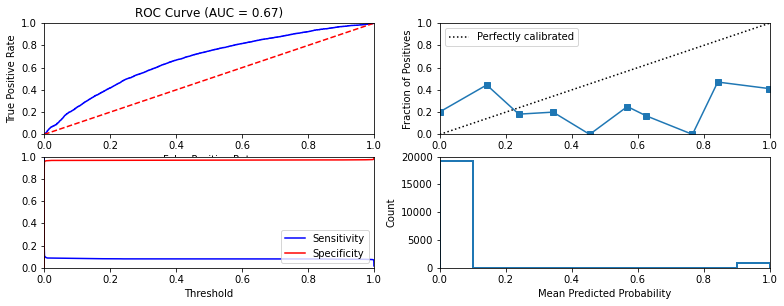


Similarity to LC grade ranking:  0.6463597892317002
Brier score: 0.2185217937046978
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.70603333]
[7.15083989e-01 9.02104561e-09 6.24682534e-09 ... 7.58108313e-16
 5.05442988e-05 7.46843915e-09]


In [15]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb,f1 = fit_classification(gnb,data_dict,model_name = 'Naives Bayes')

### $l_1$ regularized logistic regression

  Model: L1 Logistic Regression
Fit time: 247.97 seconds
Optimal parameters:
{'C': 100}

Accuracy-maximizing threshold was: 0.496202889404391
Accuracy:  0.79125
              precision    recall  f1-score   support

  No default     0.7986    0.9830    0.8813     15764
     Default     0.5511    0.0777    0.1361      4236

    accuracy                         0.7913     20000
   macro avg     0.6749    0.5303    0.5087     20000
weighted avg     0.7462    0.7913    0.7235     20000



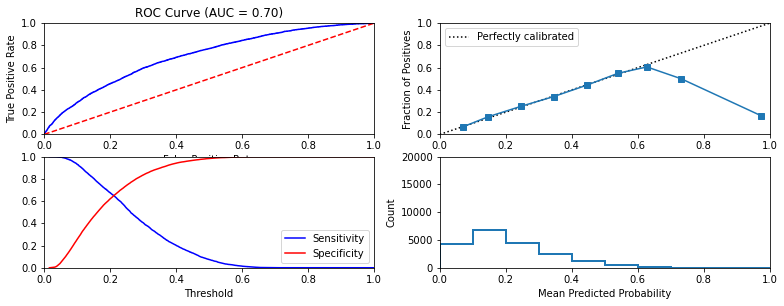


Similarity to LC grade ranking:  0.7409584385048569
Brier score: 0.1522603782367409
Were parameters on edge? : False
Score variations around CV search grid : 0.3184713375796385
[0.79293333 0.7945     0.79523333 0.79533333 0.79546667 0.79543333]
[0.05320529 0.14536011 0.07986171 ... 0.06265667 0.47172144 0.11910103]


In [16]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty = 'l1',solver='liblinear')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100,1000]}

l1_logistic,f1 = fit_classification(l1_logistic,data_dict,cv_parameters = cv_parameters,model_name = 'L1 Logistic Regression')

### $l_2$ regularized logistic regression

  Model: L2 Logistic Regression
Fit time: 18.57 seconds
Optimal parameters:
{'C': 100}

Accuracy-maximizing threshold was: 0.506554621107825
Accuracy:  0.7911
              precision    recall  f1-score   support

  No default     0.7975    0.9851    0.8814     15764
     Default     0.5549    0.0692    0.1230      4236

    accuracy                         0.7911     20000
   macro avg     0.6762    0.5271    0.5022     20000
weighted avg     0.7461    0.7911    0.7208     20000



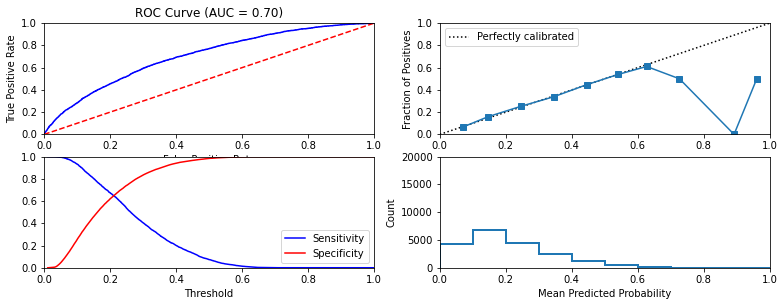


Similarity to LC grade ranking:  0.7378254834110483
Brier score: 0.15223650820683232
Were parameters on edge? : False
Score variations around CV search grid : 0.2598600108973407
[0.79323333 0.79456667 0.79516667 0.7951     0.7953     0.7953
 0.79513333]
[0.05292539 0.14397032 0.0814171  ... 0.06299891 0.47977187 0.11851776]


In [17]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty = 'l2')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100,1000,10000]}

l2_logistic,f1 = fit_classification(l2_logistic,data_dict,cv_parameters = cv_parameters,model_name = 'L2 Logistic Regression')

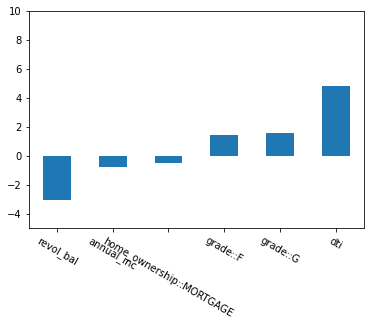

In [18]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree
Fit time: 69.02 seconds
Optimal parameters:
{'max_depth': 5, 'min_samples_leaf': 1000}

Accuracy-maximizing threshold was: 0.5034825870646766
Accuracy:  0.7882
              precision    recall  f1-score   support

  No default     0.7882    1.0000    0.8816     15764
     Default     0.0000    0.0000    0.0000      4236

    accuracy                         0.7882     20000
   macro avg     0.3941    0.5000    0.4408     20000
weighted avg     0.6213    0.7882    0.6948     20000



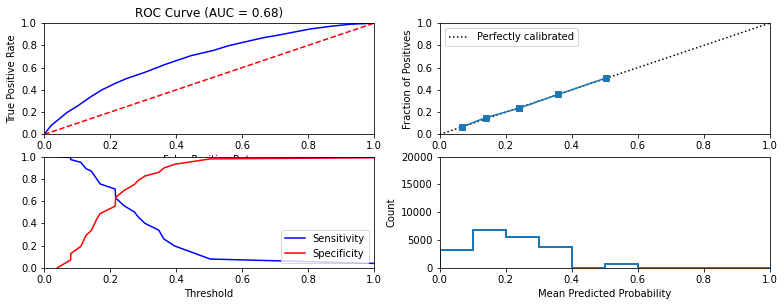


Similarity to LC grade ranking:  0.8362786955938558
Brier score: 0.1549300227803213
Were parameters on edge? : True
Score variations around CV search grid : 1.5728163505614288
[0.79146667 0.79126667 0.79096667 0.79076667 0.79263333 0.78286667
 0.789      0.79003333 0.79076667 0.79263333 0.78026667 0.78883333
 0.79003333 0.79076667 0.79263333 0.78016667 0.7885     0.79003333
 0.79076667 0.79263333 0.78036667 0.78873333 0.79003333 0.79076667
 0.79263333 0.78036667 0.78873333 0.79003333 0.79076667 0.79263333]
[0.03941441 0.14252949 0.08090422 ... 0.16950853 0.2838605  0.14252949]


In [19]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':[5,10,20,30,40,50],'min_samples_leaf':[50,100,200,500,1000]}

decision_tree,f1 = fit_classification(decision_tree,data_dict,cv_parameters = cv_parameters,model_name = 'Decision Tree')

### Random forest

  Model: Random Forest
Fit time: 1666.68 seconds
Optimal parameters:
{'min_samples_leaf': 10, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.3478553202442211
Accuracy:  0.77145
              precision    recall  f1-score   support

  No default     0.8249    0.9014    0.8614     15764
     Default     0.4396    0.2878    0.3478      4236

    accuracy                         0.7714     20000
   macro avg     0.6322    0.5946    0.6046     20000
weighted avg     0.7433    0.7714    0.7527     20000



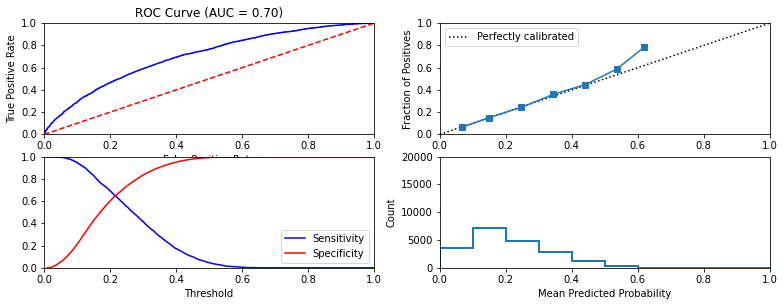


Similarity to LC grade ranking:  0.6710121878818163
Brier score: 0.15178422443190365
Were parameters on edge? : True
Score variations around CV search grid : 0.3941795613704015
[0.79176667 0.79423333 0.7949     0.7946     0.7947     0.79313333
 0.79386667 0.79433333 0.79476667 0.79466667 0.7941     0.7934
 0.7939     0.79356667 0.79366667 0.79266667 0.79283333 0.7927
 0.79283333 0.79286667 0.79266667 0.79263333 0.79263333 0.79263333
 0.79263333 0.79263333 0.79263333 0.79263333 0.79263333 0.79263333]
[0.06601555 0.15624051 0.08232042 ... 0.10955073 0.40773208 0.10412099]


In [20]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators':[10,50,100,200,500],'min_samples_leaf':[10,20,50,100,200,500]}

random_forest,f1 = fit_classification(random_forest,data_dict,cv_parameters = cv_parameters,model_name = 'Random Forest')

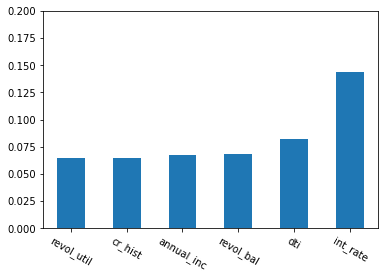

In [21]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: MLP
Fit time: 4125.64 seconds
Optimal parameters:
{'hidden_layer_sizes': (5, 5), 'max_iter': 100}

Accuracy-maximizing threshold was: 0.4999402405835882
Accuracy:  0.7891
              precision    recall  f1-score   support

  No default     0.7994    0.9777    0.8796     15764
     Default     0.5125    0.0871    0.1489      4236

    accuracy                         0.7891     20000
   macro avg     0.6560    0.5324    0.5143     20000
weighted avg     0.7387    0.7891    0.7249     20000



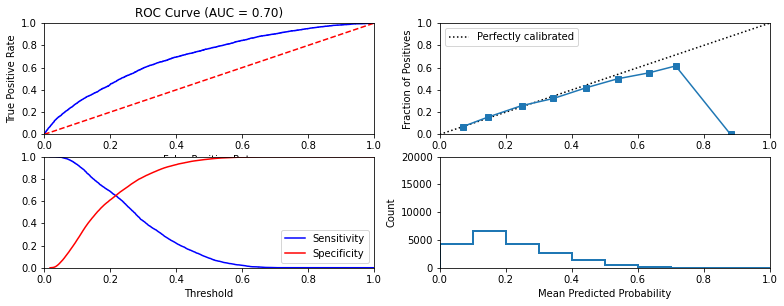


Similarity to LC grade ranking:  0.7229752534837668
Brier score: 0.15275292630815376
Were parameters on edge? : True
Score variations around CV search grid : 3.4194847696567803
[0.79296667 0.79273333 0.7931     0.7881     0.7828     0.77963333
 0.7849     0.77993333 0.7673     0.79446667 0.79293333 0.79293333
 0.79306667 0.78926667 0.79003333 0.79326667 0.789      0.7911    ]
[0.0670948  0.13936187 0.08389082 ... 0.07018989 0.40652252 0.1117363 ]


In [22]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes': [(10),(50),(100),(5,5),(10,5),(10,10)],'max_iter' : [100,200,300]}

mlp,f1 = fit_classification(mlp,data_dict,cv_parameters = cv_parameters,model_name = 'MLP')

## Train and Test logistic regression model with features derived by LendingClub

In [23]:
pd.set_option('display.max_columns', None)
data.head()

,index,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,recoveries,last_pymnt_d,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,outcome,cr_hist,train
0,0,1077501,5000.0,5000.0,36 months,10.65,B,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,27.65,0.0,1985-01-01,3.0,0.0,739.0,735.0,13648.0,83.7,5863.155187,0.0,2015-01-01,37.027454,36,0.057544,0.055947,0.413340,1.075884,False,322.963511,True
1,1,1077430,2500.0,2500.0,60 months,15.27,C,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,1.00,0.0,1999-04-01,3.0,0.0,744.0,740.0,1687.0,9.4,1014.530000,122.9,2013-04-01,16.000329,60,-0.118838,-0.118838,0.058081,0.401688,True,152.019549,False
2,2,1077175,2400.0,2400.0,36 months,15.96,C,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,8.72,0.0,2001-11-01,2.0,0.0,739.0,735.0,2956.0,98.5,3005.666844,0.0,2014-06-01,29.996509,36,0.084120,0.100956,0.502458,1.318829,False,120.971683,True
3,3,1076863,10000.0,10000.0,36 months,13.49,C,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,20.00,0.0,1996-02-01,10.0,0.0,694.0,690.0,5598.0,21.0,12231.890000,0.0,2015-01-01,37.027454,36,0.074396,0.072332,0.439784,1.130894,False,189.966940,True
4,4,1075358,3000.0,3000.0,60 months,12.69,B,1 year,RENT,80000.0,Source Verified,2011-12-01,Fully Paid,other,17.94,0.0,1996-01-01,15.0,0.0,699.0,695.0,27783.0,53.9,4066.908161,0.0,2017-01-01,61.044375,60,0.071127,0.069910,0.367104,0.861487,False,190.985441,True


Loan grade is the feature that is completly defined by LendingClub

  Model: L1-Only Grade
Fit time: 2.8 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.5425531913612411
Accuracy:  0.7882
              precision    recall  f1-score   support

  No default     0.7882    1.0000    0.8816     15764
     Default     0.0000    0.0000    0.0000      4236

    accuracy                         0.7882     20000
   macro avg     0.3941    0.5000    0.4408     20000
weighted avg     0.6213    0.7882    0.6948     20000



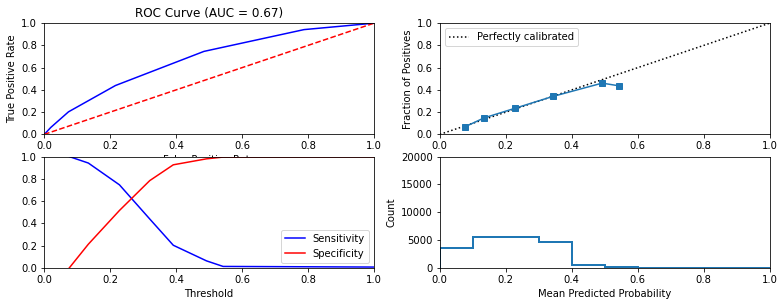


Similarity to LC grade ranking:  1.0
Brier score: 0.1560093043784593
Were parameters on edge? : False
Score variations around CV search grid : 0.025225982762242336
[0.79263333 0.79263333 0.79263333 0.79283333 0.79283333 0.79283333]
[0.07631717 0.13383752 0.07631717 ... 0.13383752 0.32       0.13383752]


In [24]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['grade']

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty = 'l1',solver='liblinear')
cv_parameters = {'C': [0.001,0.01, 0.1, 1, 10, 100]}

lc1_only_logistic,f1 = fit_classification(lc1_only_logistic,data_dict,cv_parameters = cv_parameters,model_name = 'L1-Only Grade')

  Model: L2-Only Grade
Fit time: 2.8 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.5339372723450777
Accuracy:  0.7882
              precision    recall  f1-score   support

  No default     0.7882    1.0000    0.8816     15764
     Default     0.0000    0.0000    0.0000      4236

    accuracy                         0.7882     20000
   macro avg     0.3941    0.5000    0.4408     20000
weighted avg     0.6213    0.7882    0.6948     20000



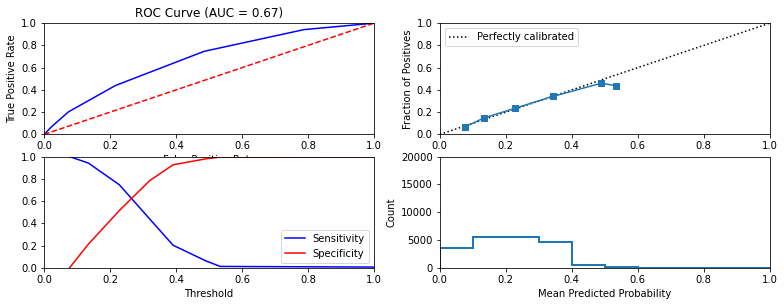


Similarity to LC grade ranking:  1.0
Brier score: 0.15599889709097037
Were parameters on edge? : False
Score variations around CV search grid : 0.07563978652771924
[0.79263333 0.79263333 0.79263333 0.79323333 0.79283333 0.79283333]
[0.07698679 0.13388001 0.07698679 ... 0.13388001 0.31984749 0.13388001]


In [25]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic  = LogisticRegression(penalty = 'l2')
cv_parameters = {'C': [0.001,0.01, 0.1, 1, 10, 100]}

lc2_only_logistic,f1 = fit_classification(lc2_only_logistic,data_dict,cv_parameters = cv_parameters,model_name = 'L2-Only Grade')

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [26]:
your_features = discrete_features + list(continuous_features) +['cr_hist','train']
your_features = [i for i in your_features if i not in ['grade','int_rate']]
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)


all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [27]:
data_dict['X_train'].shape

(30000, 48)

In [28]:
len(selected_features)

48

In [38]:
#Running the best models with 100 different random seeds
gnb_f1 = []
l1log_f1=[]
l2log_f1=[]
dt_f1=[]
rf_f1=[]
mlp_f1=[]

for i in range(0,100):
      
    data_dict = prepare_data(feature_subset = your_features, random_state=i)

    all_features = pd.Series(continuous_features + discrete_features_dummies)
    idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
    selected_features = all_features[idx]
    selected_features.reset_index(drop=True,inplace=True)

    gnb = GaussianNB()
    gnb,f1 = fit_classification(gnb,data_dict,model_name = 'Naives Bayes',print_to_screen=False,output_to_file=False)
    gnb_f1.append(f1)
    
    ## Train and test a l_1 regularized logistic regression classifier

    #l1_logistic = LogisticRegression(penalty = 'l1',solver='liblinear')
    l1_logistic1,f1 = fit_classification(l1_logistic['model'],data_dict,model_name = 'L1 Logistic Regression',print_to_screen=False,output_to_file=False)
    l1log_f1.append(f1)
    
    ## Train and test a l_2 regularized logistic regression classifier

    #l2_logistic = LogisticRegression(penalty = 'l2')
    l2_logistic1,f1 = fit_classification(l2_logistic['model'],data_dict,model_name = 'L2 Logistic Regression',print_to_screen=False,output_to_file=False)
    l2log_f1.append(f1)
    
    
    ## Train and test a decision tree classifier

    #decision_tree = DecisionTreeClassifier()
    decision_tree1,f1 = fit_classification(decision_tree['model'],data_dict,model_name = 'Decision Tree',print_to_screen=False,output_to_file=False)
    dt_f1.append(f1)
    
    ## Train and test a random forest classifier

    #random_forest = RandomForestClassifier()
    random_forest1,f1 = fit_classification(random_forest['model'],data_dict,model_name = 'Random Forest',print_to_screen=False,output_to_file=False)
    rf_f1.append(f1)
    
    
    ## Train and test a multi-layer perceptron classifier

    #mlp = MLPClassifier()
    mlp1,f1 = fit_classification(mlp['model'],data_dict,model_name = 'Multi-layer Perceptron',print_to_screen=False,output_to_file=False)
    mlp_f1.append(f1)
    print("Done",i)

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42
Done 43
Done 44
Done 45
Done 46
Done 47
Done 48
Done 49
Done 50
Done 51
Done 52
Done 53
Done 54
Done 55
Done 56
Done 57
Done 58
Done 59
Done 60
Done 61
Done 62
Done 63
Done 64
Done 65
Done 66
Done 67
Done 68
Done 69
Done 70
Done 71
Done 72
Done 73
Done 74
Done 75
Done 76
Done 77
Done 78
Done 79
Done 80
Done 81
Done 82
Done 83
Done 84
Done 85
Done 86
Done 87
Done 88
Done 89
Done 90
Done 91
Done 92
Done 93
Done 94
Done 95
Done 96
Done 97
Done 98
Done 99


In [39]:
combined = [gnb_f1,l1log_f1,l2log_f1,dt_f1,rf_f1,mlp_f1]

In [40]:
combined_df = pd.DataFrame(combined)

In [41]:
combined_df.to_csv('F1_scores.csv') 

In [ ]:
models = [gnb['model'],l1_logistic['model'],l2_logistic['model'],decision_tree['model'],random_forest['model'],mlp['model']]

In [43]:
combined_models = pd.DataFrame(models)

In [44]:
combined_models.to_csv('models.csv') 

Question 4

In [45]:
#df = pd.read_csv('models.csv')
#your_model = df['0'].iloc[4]

In [46]:
#max_features = auto is the default
your_model = random_forest['model']

  Model: Your Model
Fit time: 21.25 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.3170944876264307
Accuracy:  0.7684
              precision    recall  f1-score   support

  No default     0.8327    0.8861    0.8586     15871
     Default     0.4192    0.3158    0.3602      4129

    accuracy                         0.7684     20000
   macro avg     0.6259    0.6010    0.6094     20000
weighted avg     0.7473    0.7684    0.7557     20000



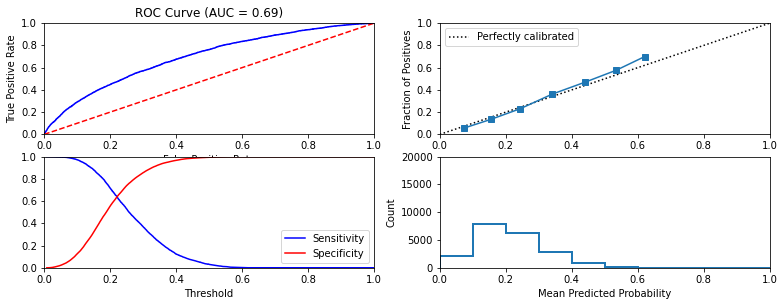


Similarity to LC grade ranking:  0.45966864980156813
Brier score: 0.15077026379682265
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.78863333]
[0.11308593 0.23703976 0.23472773 ... 0.23662135 0.18634564 0.20528105]


In [47]:
out = fit_classification(your_model,data_dict,model_name = 'Your Model',print_to_screen=True,output_to_file=True)

In [48]:
len(out[0]['y_pred_labels'])

20000

In [49]:
len(data[data_dict['test_set']]['grade'])

20000

In [50]:
dummy11 = pd.merge(pd.DataFrame(out[0]['y_pred_labels']),data[data_dict['test_set']]['grade'].reset_index(drop = True),right_index = True, left_index = True)

In [51]:
dummy11.groupby('grade').mean()

,0
grade,
A,0.005351
B,0.045076
C,0.160614
D,0.291467
E,0.462614
F,0.626050
G,0.645455


## Time stability test of YOURMODEL

In [52]:
start_date_train = datetime.date(2010,1,1)
end_date_train = datetime.date(2010,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data

rf_2010,f1_2010=fit_classification(your_model,data_dict_test,model_name = 'Random Forest',print_to_screen=False,output_to_file=False)


## Define the time window of your train and test data
start_date_train = datetime.date(2016,1,1)
end_date_train = datetime.date(2016,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data

rf1_2016,f1_2016=fit_classification(your_model,data_dict_test,model_name = 'Random Forest',print_to_screen=False,output_to_file=False)

print("f1_2010: ",f1_2010)
print("f1_2016: ",f1_2016)

f1_2010:  0.7852554428586984
f1_2016:  0.7894034536891681


## Train and test YOURMODEL on the original data

In [14]:
dir_cs = 'C:\\Users\\kirth\\Downloads\\MLPS\\case_study_data\\2003_download'

In [15]:

cols_to_pick = ['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
'annual_inc', 'verification_status','issue_d','loan_status','purpose', 'title',
'zip_code','addr_state', 'dti', 'total_pymnt','delinq_2yrs','earliest_cr_line',
'open_acc', 'pub_rec', 'last_pymnt_d', 'last_pymnt_amnt', 'fico_range_high',
'fico_range_low', 'last_fico_range_high', 'last_fico_range_low',
'application_type', 'revol_bal', 'revol_util', 'recoveries']
# list of features to use for this study as indicated in the handout



In [16]:
len(cols_to_pick)

36

In [17]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += "/"
    
    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in range(len(all_files)):
        print("    Reading file " + all_files[i])
        output[i] = pd.read_csv(directory + "\\" +all_files[i],dtype = str,skiprows=1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = ~ output[i]['id'].str.isnumeric() # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][~invalid_rows] # remove invalid rows
    
    return output # return dictionary of dataframe

In [18]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)


Directory C:\Users\kirth\Downloads\MLPS\case_study_data\2003_download/ has 20 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStat

In [19]:
data_cs = pd.DataFrame(columns = list(files_cs[1].columns))  # combine "files_cs" into a pandas dataframe
for i in files_cs.keys():
    data_cs = pd.concat([data_cs,files_cs[i]])
    
data_cs.reset_index(drop = True) 

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000,5000,4975,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500,2500,2500,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400,2400,2400,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000,10000,10000,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000,3000,3000,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777771,158872331,NaN,3000,3000,3000,36 months,17.74%,108.07,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2777772,158833440,NaN,10000,10000,10000,36 months,6.46%,306.31,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2777773,158748525,NaN,19000,19000,19000,36 months,6.46%,581.99,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2777774,158298751,NaN,10000,10000,10000,60 months,28.80%,316.21,D,D5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
final_data = data_cs[cols_to_pick]
final_data = final_data.reset_index(drop = True)
final_data.shape


(2777776, 36)

In [21]:
final_data = final_data.dropna()

In [22]:
final_data.shape

(2507279, 36)

In [23]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data.loc[(final_data['loan_status'] == 'Fully Paid') | (final_data['loan_status'] == 'Charged Off') | (final_data['loan_status'] == 'Default')]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1447454 rows


In [32]:
pd.set_option("display.max_columns", None)
# display the dataframe head
final_data.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,total_pymnt,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,last_pymnt_d,last_pymnt_amnt,fico_range_high,fico_range_low,last_fico_range_high,last_fico_range_low,application_type,revol_bal,revol_util,recoveries
1,1077430,2500,2500,2500,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000,Source Verified,Dec-2011,Charged Off,car,bike,309xx,GA,1,1014.53,0,Apr-1999,3,0,Apr-2013,119.66,744,740,499,0,Individual,1687,9.4%,122.9
3,1076863,10000,10000,10000,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200,Source Verified,Dec-2011,Fully Paid,other,personel,917xx,CA,20,12231.890000000902,0,Feb-1996,10,0,Jan-2015,357.48,694,690,604,600,Individual,5598,21%,0.0
4,1075358,3000,3000,3000,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000,Source Verified,Dec-2011,Fully Paid,other,Personal,972xx,OR,17.94,4066.9081610817,0,Jan-1996,15,0,Jan-2017,67.3,699,695,684,680,Individual,27783,53.9%,0.0
5,1075269,5000,5000,5000,36 months,7.90%,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000,Source Verified,Dec-2011,Fully Paid,wedding,My wedding loan I promise to pay back,852xx,AZ,11.2,5632.209999999401,0,Nov-2004,9,0,Jan-2015,161.03,734,730,564,560,Individual,7963,28.3%,0.0
6,1069639,7000,7000,7000,60 months,15.96%,170.08,C,C5,Southern Star Photography,8 years,RENT,47004,Not Verified,Dec-2011,Fully Paid,debt_consolidation,Loan,280xx,NC,23.51,10137.840007529006,0,Jul-2005,7,0,May-2016,1313.76,694,690,654,650,Individual,17726,85.6%,0.0


In [34]:
print(len(final_data['title'].unique()))
print(len(final_data['zip_code'].unique()))
print(len(final_data['addr_state'].unique()))

 ##Too many unique values for these columns so dropping them from the categorical list to avoid memory issues.

56871
934
51


In [35]:
############ Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt','funded_amnt','funded_amnt_inv','installment','annual_inc','dti', 'revol_bal', 'delinq_2yrs', 
              'open_acc', 'pub_rec','fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries','last_pymnt_amnt',
              'last_fico_range_high','last_fico_range_low']
cat_cols = ['term','grade','sub_grade','emp_length','home_ownership','verification_status','loan_status','purpose',
           'application_type'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

In [36]:
for i in float_cols:
    final_data[i] = final_data[i].astype(float) # typecast float columns
    
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns

In [37]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date

In [38]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data.loc[(final_data['issue_d'] >= datetime.date(2010, 1, 1))]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 6136 rows


In [39]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data.loc[final_data['loan_length'] != 0]  # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 11090 rows


In [40]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
final_data["outcome"] = ((final_data['loan_status'] == 'Charged Off') | (final_data['loan_status'] == 'Default'))

In [41]:
dummy_columns = pd.get_dummies(final_data[cat_cols],drop_first = True)

In [42]:
dummy_columns.shape

(1042599, 74)

In [43]:
type(dummy_columns)

pandas.core.frame.DataFrame

In [44]:
#Removing date columns
X = pd.concat([final_data[float_cols + perc_cols], dummy_columns], axis=1)
X.shape

(1042599, 93)

In [45]:
y= final_data['outcome']
y.shape

(1042599,)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3)

In [47]:
X_train.shape

(729819, 93)

In [49]:
#Using the values from the excel....n_estimator is the default value
your_model = RandomForestClassifier(min_samples_leaf=10)
your_model.fit(X_train, y_train)
predictions = your_model.predict(X_test)


In [50]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    249492
        True       1.00      1.00      1.00     63288

    accuracy                           1.00    312780
   macro avg       1.00      1.00      1.00    312780
weighted avg       1.00      1.00      1.00    312780



## Test regression models

In [16]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [17]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10]}

reg_lasso = fit_regression(linear_model.Lasso(),data_dict,cv_parameters = cv_parameters,model_name = 'L1-Regression')

  Model: L1-Regression  Return column: ret_PESS
Fit time: 10.64 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: 0.024315159165224753
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -13.83808457089396
All test scores : [-0.09604513 -0.09606439 -0.09348403 -0.09224908 -0.09725215 -0.10501459
 -0.10501459 -0.10501459 -0.10501459]
  Model: L1-Regression  Return column: ret_OPT
Fit time: 17.01 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: 0.021911854565467848
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 587.5970387790397
All test scores : [ 0.00105372  0.00145906  0.0023882   0.00213098 -0.00648091 -0.0116448
 -0.0116448  -0.0116448  -0.0116448 ]
  Model: L1-Regression  Return column: ret_INTa
Fit time: 21.96 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: 0.0322442238781927
Were parameters on edge (model) : False
Score variations around CV search grid (mo

In [18]:

cv_parameters = {'alpha': [0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10]}

reg_lasso_sep = fit_regression(linear_model.Lasso(),data_dict,cv_parameters = cv_parameters,separate = True,model_name = 'L1-Regression')

  Model: L1-Regression  Return column: ret_PESS
Fit time: 14.09 seconds
Optimal parameters:
model_0: {'alpha': 0.0001} model_1 {'alpha': 1e-05}

Testing r2 scores:
model_0: 0.2618947583724418
model_1: 0.15554259304499485
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : -105.05424142172582
All test scores : [-0.34339873 -0.34298335 -0.3319473  -0.31017107 -0.44014716 -0.63601893
 -0.63601893 -0.63601893 -0.63601893]
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : -84.17724611774773
All test scores : [-0.26746134 -0.26701232 -0.26425574 -0.27826944 -0.29515494 -0.41337295
 -0.48669894 -0.48669894 -0.48669894]
  Model: L1-Regression  Return column: ret_OPT
Fit time: 13.54 seconds
Optimal parameters:
model_0: {'alpha': 0.0001} model_1 {'alpha': 1e-05}

Testing r2 scores:
model_0: 0.716041346781412
model_1: 0.15087850338524422
Were parameters on edge (model_0) : False
Score variations around CV search g

### $l_2$ regularized linear regressor

In [19]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}


reg_ridge = fit_regression(linear_model.Ridge(),data_dict,cv_parameters = cv_parameters,model_name = 'L2-Regression')


  Model: L2-Regression  Return column: ret_PESS
Fit time: 2.24 seconds
Optimal parameters:
{'alpha': 1000}

Testing r2 score: 0.02255202296780423
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -8.523602397350968
All test scores : [-0.09610542 -0.09608861 -0.09604093 -0.09601532 -0.09597182 -0.09562735
 -0.09469168 -0.09448007 -0.08993499 -0.08855716 -0.0943337 ]
  Model: L2-Regression  Return column: ret_OPT
Fit time: 1.97 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.020901630835565066
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 283.57651171686945
All test scores : [ 0.00084972  0.00086089  0.00088935  0.00090444  0.0009504   0.00133936
  0.00280979  0.00317512  0.00185493 -0.00137008 -0.00582878]
  Model: L2-Regression  Return column: ret_INTa
Fit time: 1.92 seconds
Optimal parameters:
{'alpha': 1000}

Testing r2 score: 0.029804900380990595
Were parameters on edge (model) : False
S

In [20]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}


reg_ridge_sep = fit_regression(linear_model.Ridge(),data_dict,cv_parameters = cv_parameters,separate = True,model_name = 'L2-Regression')


  Model: L2-Regression  Return column: ret_PESS
Fit time: 1.83 seconds
Optimal parameters:
model_0: {'alpha': 100} model_1 {'alpha': 0.1}

Testing r2 scores:
model_0: 0.2712672026429408
model_1: 0.15374972197483394
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : -88.4380194402995
All test scores : [-0.35495297 -0.35489957 -0.35438644 -0.35045637 -0.3433709  -0.34319756
 -0.3411746  -0.31588463 -0.26609896 -0.29777294 -0.50143162]
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : -66.63054363562682
All test scores : [-0.26747314 -0.26751696 -0.26757164 -0.26753872 -0.26710156 -0.26480699
 -0.26563368 -0.26771586 -0.27470856 -0.32727083 -0.44124932]
  Model: L2-Regression  Return column: ret_OPT
Fit time: 1.67 seconds
Optimal parameters:
model_0: {'alpha': 10} model_1 {'alpha': 0.1}

Testing r2 scores:
model_0: 0.7170930037051582
model_1: 0.14906511156260538
Were parameters on edge (model_0) : False
S

### Multi-layer perceptron regressor

In [21]:
## trying multi-layer perceptron regression with hyper-parameters

reg_mlp = MLPRegressor()

cv_parameters = {'alpha': [0.001,0.001,0.01,0.1,1,10],'hidden_layer_sizes':[(1), (10), (50), (5, 5), (10, 10)]}

reg_mlp = fit_regression(reg_mlp,data_dict,cv_parameters = cv_parameters,model_name = 'MLP Regressor')

  Model: MLP Regressor  Return column: ret_PESS
Fit time: 234.31 seconds
Optimal parameters:
{'alpha': 0.1, 'hidden_layer_sizes': 50}

Testing r2 score: 0.022784890251337786
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -122.55023300457334
All test scores : [-0.12177411 -0.13508686 -0.17083754 -0.10643719 -0.13330886 -0.10281873
 -0.10869455 -0.16092549 -0.10887604 -0.11260869 -0.11329823 -0.1344431
 -0.1356038  -0.10965216 -0.07770408 -0.12362947 -0.09701919 -0.07676359
 -0.10010643 -0.08960142 -0.1044819  -0.1043234  -0.08815981 -0.11569273
 -0.09533459 -0.10028327 -0.08865022 -0.09458468 -0.09946859 -0.10557475]
  Model: MLP Regressor  Return column: ret_OPT
Fit time: 207.4 seconds
Optimal parameters:
{'alpha': 0.1, 'hidden_layer_sizes': (10, 10)}

Testing r2 score: 0.014095754198354404
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 4294.508285744536
All test scores : [-0.02654083 -0.01539534 -0.0278

In [22]:
## trying multi-layer perceptron regression with hyper-parameters

reg_mlp_sep = MLPRegressor()

cv_parameters = {'alpha': [0.001,0.001,0.01,0.1,1,10],'hidden_layer_sizes':[(1), (10), (50), (5, 5), (10, 10)]}

reg_mlp_sep = fit_regression(reg_mlp_sep,data_dict,cv_parameters = cv_parameters,separate = True,model_name = 'MLP Regressor')

  Model: MLP Regressor  Return column: ret_PESS
Fit time: 265.77 seconds
Optimal parameters:
model_0: {'alpha': 0.1, 'hidden_layer_sizes': 50} model_1 {'alpha': 1, 'hidden_layer_sizes': (5, 5)}

Testing r2 scores:
model_0: 0.2668195419255378
model_1: 0.06700680620834276
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : -486.583988789244
All test scores : [-0.91475084 -1.01540409 -0.82258474 -0.91617922 -0.45631796 -0.87246412
 -0.7258646  -0.62962917 -0.65348462 -0.53953107 -1.49793045 -0.5348381
 -0.86874591 -0.466073   -0.38540847 -0.87072962 -0.54584957 -0.25536504
 -0.62432982 -0.31017503 -0.59286373 -0.39587547 -0.42560955 -0.60775438
 -0.65140008 -0.57725478 -0.69963964 -0.65125846 -0.60862369 -0.65977015]
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : -429.1012088054895
All test scores : [-1.27464646 -0.46963755 -0.50313741 -0.39755607 -0.46562342 -0.55917686
 -0.58006018 -0.53853653 -0.3961

### Random forest regressor

In [23]:
## trying random forest regression with hyper-parameters

reg_rf = RandomForestRegressor()

cv_parameters = {'n_estimators':[10,25,50,75,100],'min_samples_leaf':[10,20,50,75,100,150]}

reg_rf = fit_regression(reg_rf,data_dict,cv_parameters = cv_parameters,model_name = 'Random Forest Regressor')

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 987.72 seconds
Optimal parameters:
{'min_samples_leaf': 50, 'n_estimators': 50}

Testing r2 score: 0.0438356801973927
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -50.810081626561285
All test scores : [-0.11527197 -0.0971282  -0.0859628  -0.08583191 -0.08396882 -0.10251661
 -0.08201464 -0.079737   -0.07951413 -0.07823641 -0.08369353 -0.07941042
 -0.07643519 -0.07766426 -0.07717361 -0.08277972 -0.07806759 -0.07693976
 -0.07708886 -0.07725273 -0.08259904 -0.07904139 -0.07784465 -0.07832953
 -0.07827056 -0.0839212  -0.08075549 -0.07860203 -0.07832597 -0.07919951]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 948.83 seconds
Optimal parameters:
{'min_samples_leaf': 75, 'n_estimators': 75}

Testing r2 score: 0.02879100469809659
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 653.0470557845762
All test scores : [-3.641634

In [24]:
## trying random forest regression with hyper-parameters

reg_rf_sep = RandomForestRegressor()

cv_parameters = {'n_estimators':[25,50,75,100,150,200],'min_samples_leaf':[20,50,75,100,150,250]}

reg_rf_sep = fit_regression(reg_rf_sep,data_dict,cv_parameters = cv_parameters,separate = True,model_name = 'Random Forest Regressor')

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 1467.61 seconds
Optimal parameters:
model_0: {'min_samples_leaf': 20, 'n_estimators': 200} model_1 {'min_samples_leaf': 20, 'n_estimators': 150}

Testing r2 scores:
model_0: 0.37626988858959687
model_1: 0.1612436029558315
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -17.546879398043078
All test scores : [-0.25710633 -0.25468919 -0.25108195 -0.25583003 -0.25448408 -0.25016522
 -0.28003671 -0.28519076 -0.27973517 -0.28197301 -0.27924744 -0.2813534
 -0.29166656 -0.29346622 -0.29267493 -0.29237553 -0.28900902 -0.28930026
 -0.29378074 -0.29396904 -0.29342197 -0.29396128 -0.29406141 -0.29339626
 -0.28809827 -0.28019557 -0.28317424 -0.28465013 -0.28244623 -0.28495673
 -0.28837268 -0.28464792 -0.28729423 -0.28560833 -0.28709941 -0.28524698]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -10.654629805285092
All test scores : [-0.25699418

In [17]:
## trying random forest regression with hyper-parameters

reg_rf = RandomForestRegressor()

cv_parameters = {'n_estimators':[10,25,50,75,100],'min_samples_leaf':[10,20,50,75,100,150]}

reg_rf = fit_regression(reg_rf,data_dict,cv_parameters = cv_parameters,model_name = 'Random Forest Regressor')

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 2602.82 seconds
Optimal parameters:
{'min_samples_leaf': 50, 'n_estimators': 50}

Testing r2 score: 0.043834494344655694
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -50.765642403968286
All test scores : [-0.11525515 -0.09717298 -0.08596338 -0.08576551 -0.08395972 -0.10238568
 -0.08198961 -0.0796967  -0.07950192 -0.07824579 -0.08369243 -0.0794167
 -0.07644656 -0.0776631  -0.0771699  -0.08278859 -0.07806975 -0.07695374
 -0.07708939 -0.07724168 -0.08256862 -0.0790279  -0.07783512 -0.07831812
 -0.07825909 -0.0839063  -0.08075187 -0.07861324 -0.07832402 -0.07919596]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 1661.93 seconds
Optimal parameters:
{'min_samples_leaf': 75, 'n_estimators': 75}

Testing r2 score: 0.028792963237133984
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 653.4987484207579
All test scores : [-3.64

In [18]:
## trying random forest regression with hyper-parameters

reg_rf_sep = RandomForestRegressor()

cv_parameters = {'n_estimators':[25,50,75,100,150,200],'min_samples_leaf':[20,50,75,100,150,250]}

reg_rf_sep = fit_regression(reg_rf_sep,data_dict,cv_parameters = cv_parameters,separate = True,model_name = 'Random Forest Regressor')

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 1453.38 seconds
Optimal parameters:
model_0: {'min_samples_leaf': 20, 'n_estimators': 200} model_1 {'min_samples_leaf': 20, 'n_estimators': 150}

Testing r2 scores:
model_0: 0.3762656195998696
model_1: 0.16123640586948418
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -17.50342997442371
All test scores : [-0.256916   -0.25492767 -0.25112949 -0.25567268 -0.25449262 -0.25025982
 -0.28003917 -0.28517901 -0.27972004 -0.28197009 -0.27920759 -0.28134924
 -0.29166319 -0.29345495 -0.29267934 -0.29239782 -0.28900636 -0.28930486
 -0.2937758  -0.29396691 -0.29340708 -0.29396631 -0.29406387 -0.29339676
 -0.28809998 -0.28019895 -0.28317509 -0.28464613 -0.28244871 -0.28495792
 -0.28837268 -0.28464711 -0.2872937  -0.28560849 -0.28709977 -0.28524665]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -10.647011045741806
All test scores : [-0.25694717

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [48]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = np.matmul(pf_test['funded_amnt'],pf_test[ret_col])/np.sum(pf_test['funded_amnt'])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find their return
            ret_test = np.matmul(pf_test['funded_amnt'],pf_test[ret_col])/np.sum(pf_test['funded_amnt'])
            

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = np.matmul(pf_test['funded_amnt'],pf_test[ret_col])/np.sum(pf_test['funded_amnt'])
            
            #print(pf_test['funded_amnt'].mean())

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find their return
            ret_test = np.matmul(pf_test['funded_amnt'],pf_test[ret_col])/np.sum(pf_test['funded_amnt'])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [63]:
def best_investments(data_dict,
                        strategy = 'best', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):

    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'best':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]]

            ## Find the average return for these loans
            ret_test = pf_test['funded_amnt']*pf_test[ret_col]/pf_test['funded_amnt']
            
            args = (-1*ret_test).argsort()
            
            #print(type(ret_test),len(ret_test),type(args),args.shape)
            
            ret_test = np.array(ret_test[args[:1000]]).mean()
    
            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}
            
    return out

In [20]:
data_dict['X_train'].shape

(30000, 56)

In [21]:
your_model = RandomForestClassifier(min_samples_leaf=10)

In [22]:
## Test investment strategies using the best performing regressor
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)

ret_PESS = []
ret_OPT = []
ret_INTa = []
ret_INTb = []

for i in range(100):
    strat_rand=test_investments(data_dict,classifier=None,regressor=None,strategy=test_strategy,num_loans=1000,random_state=i,output_to_file=False)
    ret_PESS.append(strat_rand['ret_PESS']['average return'])
    ret_OPT.append(strat_rand['ret_OPT']['average return'])
    ret_INTa.append(strat_rand['ret_INTa']['average return'])
    ret_INTb.append(strat_rand['ret_INTb']['average return'])
    

print(col_list[0] + ': ' + str(np.array(ret_PESS).mean()))
print(col_list[1] + ': ' + str(np.array(ret_OPT).mean()))
print(col_list[2] + ': ' + str(np.array(ret_INTa).mean()))
print(col_list[3] + ': ' + str(np.array(ret_INTb).mean()))

strategy: Random
ret_PESS: -0.001306339886505543
ret_OPT: 0.049803724895582706
ret_INTa: 0.4235852183508626
ret_INTb: 1.2625129132137878


In [49]:
from sklearn.metrics import f1_score
test_strategy = 'Default-based'

a,f1_score_a=fit_classification(your_model,data_dict,print_to_screen=False,output_to_file=False)

ret_PESS = []
ret_OPT = []
ret_INTa = []
ret_INTb = []


print('strategy:',test_strategy)
    
for i in range(100):
    strat_def = test_investments(data_dict,classifier=a,regressor=None,strategy=test_strategy,num_loans=1000,random_state=i,output_to_file=False)
    ret_PESS.append(strat_def['ret_PESS']['average return'])
    ret_OPT.append(strat_def['ret_OPT']['average return'])
    ret_INTa.append(strat_def['ret_INTa']['average return'])
    ret_INTb.append(strat_def['ret_INTb']['average return'])
    

print(col_list[0] + ': ' + str(np.array(ret_PESS).mean()))
print(col_list[1] + ': ' + str(np.array(ret_OPT).mean()))
print(col_list[2] + ': ' + str(np.array(ret_INTa).mean()))
print(col_list[3] + ': ' + str(np.array(ret_INTb).mean()))


strategy: Default-based
ret_PESS: 0.01746205265827758
ret_OPT: 0.055689629622771915
ret_INTa: 0.42262104503480663
ret_INTb: 1.2644764403644275


In [42]:
test_strategy = 'Return-based'

ret_PESS = []
ret_OPT = []
ret_INTa = []
ret_INTb = []



print('strategy:',test_strategy)
for i in range(100):    
    strat_ret = (test_investments(data_dict,classifier=None,regressor=reg_rf,strategy=test_strategy,num_loans=1000,random_state=i,output_to_file=False))
    ret_PESS.append(strat_ret['ret_PESS']['average return'])
    ret_OPT.append(strat_ret['ret_OPT']['average return'])
    ret_INTa.append(strat_ret['ret_INTa']['average return'])
    ret_INTb.append(strat_ret['ret_INTb']['average return'])
    
print(col_list[0] + ': ' + str(np.array(ret_PESS).mean()))
print(col_list[1] + ': ' + str(np.array(ret_OPT).mean()))
print(col_list[2] + ': ' + str(np.array(ret_INTa).mean()))
print(col_list[3] + ': ' + str(np.array(ret_INTb).mean()))

strategy: Return-based
ret_PESS: 0.032549214642539084
ret_OPT: 0.036376564739006766
ret_INTa: 0.41624906866225236
ret_INTb: 1.2866556312188064


In [44]:
test_strategy = 'Default-return-based'


ret_PESS = []
ret_OPT = []
ret_INTa = []
ret_INTb = []



#your_model = RandomForestClassifier(min_samples_leaf=10, n_estimators=500)
class_rf,f1_score_def=fit_classification(your_model,data_dict,print_to_screen=False,output_to_file=False)

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {'n_estimators':[50,100],'min_samples_leaf':[50,100],'max_features':['auto']}

reg_separate = fit_regression(RandomForestRegressor(),data_dict,cv_parameters = cv_parameters,model_name = 'Random Forest Regressor',separate=True)

print('strategy:',test_strategy)
for i in range(100):   
    strat_defret = test_investments(data_dict,classifier=class_rf,regressor=reg_separate,strategy=test_strategy,num_loans=1000,random_state=i,output_to_file=False)
    ret_PESS.append(strat_defret['ret_PESS']['average return'])
    ret_OPT.append(strat_defret['ret_OPT']['average return'])
    ret_INTa.append(strat_defret['ret_INTa']['average return'])
    ret_INTb.append(strat_defret['ret_INTb']['average return'])
    
print(col_list[0] + ': ' + str(np.array(ret_PESS).mean()))
print(col_list[1] + ': ' + str(np.array(ret_OPT).mean()))
print(col_list[2] + ': ' + str(np.array(ret_INTa).mean()))
print(col_list[3] + ': ' + str(np.array(ret_INTb).mean()))

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 359.99 seconds
Optimal parameters:
model_0: {'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 100} model_1 {'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 100}

Testing r2 scores:
model_0: 0.35540624168478685
model_1: 0.15897925046286254
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -4.983535333875441
All test scores : [-0.28280882 -0.28002412 -0.29397922 -0.29333509]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -4.680962899716597
All test scores : [-0.25320546 -0.24730065 -0.2588767  -0.25547229]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 340.27 seconds
Optimal parameters:
model_0: {'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 50} model_1 {'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 50}

Testing r2 scores:
model_0: 0.735543033247582


In [64]:
test_strategy = 'best'

print('strategy:',test_strategy)
  
strat_best = (best_investments(data_dict,strategy=test_strategy,num_loans=1000,random_state=i,output_to_file=False))
ret_PESS_best = strat_best['ret_PESS']['average return']
ret_OPT_best = strat_best['ret_OPT']['average return']
ret_INTa_best = strat_best['ret_INTa']['average return']
ret_INTb_best = strat_best['ret_INTb']['average return']
    
print(col_list[0] + ': ' + str(ret_PESS_best))
print(col_list[1] + ': ' + str(ret_OPT_best))
print(col_list[2] + ': ' + str(ret_INTa_best))
print(col_list[3] + ': ' + str(ret_INTb_best))

strategy: best
ret_PESS: 0.1003976993332276
ret_OPT: 0.23371219777471391
ret_INTa: 0.6136832195692166
ret_INTb: 1.8562623510695344


## Sensitivity test of portfolio size

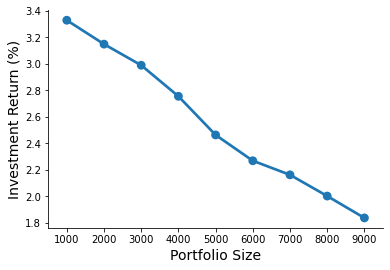

In [50]:
## Test the best-performing data-driven strategy on different portfolio sizes

test_strategy = 'Default-return-based'
result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict,classifier=class_rf,regressor=reg_separate,strategy=test_strategy,num_loans=num_loans,output_to_file=False)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()